# <center> [Houses prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
### <center>Predict sales prices and practice feature engineering, RFs, and gradient boosting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

pd.set_option('display.max_columns', 1000) # Display all variables

# Leear datos

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
#!wget -P ./../data/ https://raw.githubusercontent.com/SaturdaysAI-Murcia/machine-learning/master/data/titanic_train.csv

In [3]:
df_train = pd.read_csv("../data/house-prices-train.csv", index_col='Id')
df_test  = pd.read_csv("../data/house-prices-test.csv", index_col='Id')

In [4]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
ProfileReport(df_train)

# Qué queremos predecir? -> `df.SalePrice`

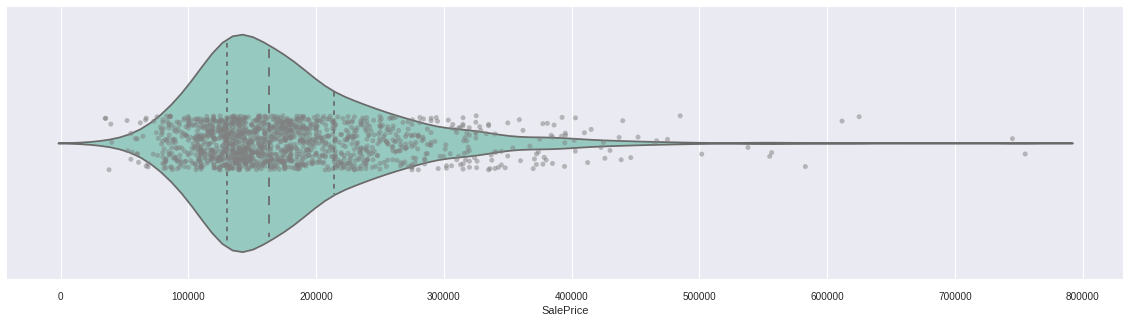

In [5]:
def ditribution(variable, size):
    plt.figure(figsize=size)
    sns.violinplot(variable, palette="Set3", inner="quart" )
    sns.stripplot(variable, color="grey", alpha=.5);

ditribution(df_train.SalePrice, size=(20,5))

# Remove Skew

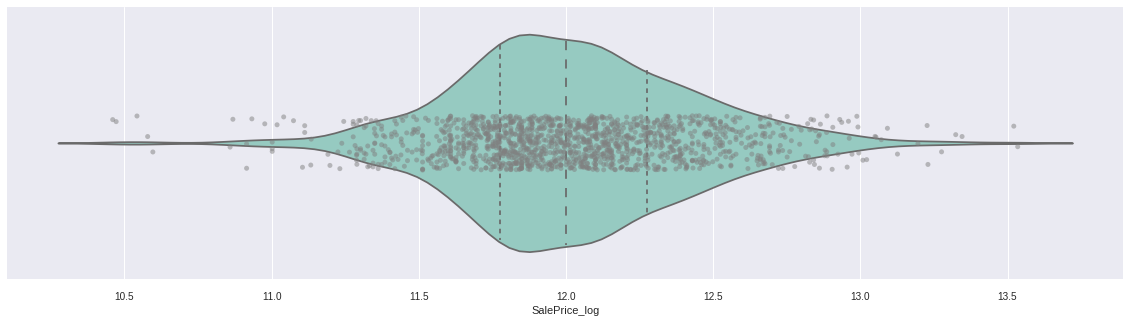

In [6]:
df_train["SalePrice_log"] = np.log1p(df_train.SalePrice)
ditribution(df_train.SalePrice_log, size=(20,5))

# Con que metrica se nos evalua? [Root Mean Square Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

In [7]:
# Merge Train and Test to evaluate ranges and missings
#df_train = df_train[df_train.columns.values[:-2]]
#df = df_train.append(df_test, ignore_index = True)

# Numeric & Categoric vars

In [8]:
cat = df_train.select_dtypes(include=[object]).columns#.values.tolist()
num = df_train.select_dtypes(exclude=[object]).columns#.values.tolist()
num = num.drop("SalePrice")
num = num.drop("SalePrice_log")

train_cat = df_train[cat]
train_num = df_train[num]

print("Numerical features : ", len(num))
print("Categorical features : ", len(cat))

Numerical features :  36
Categorical features :  43


# Handle Missing Data for continuous data
- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column
- Remove outliers using Median Absolute Deviation
- Calculate skewness for each variable and if greater than 0.75 transform it
- Apply the sklearn.Normalizer to each column

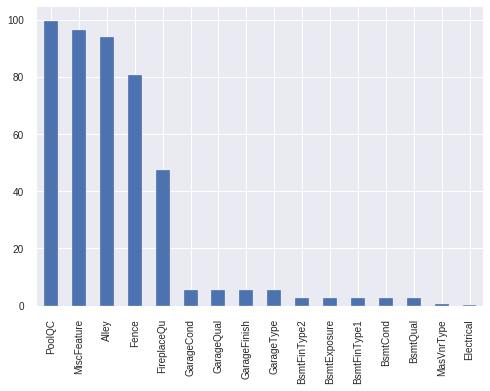

In [9]:
def plot_missings(df):
    missing = df.isnull().sum()
    missing = missing/df.isnull().count()*100
    missing = missing[missing > 0]
    missing.sort_values(ascending=False, inplace=True)
    missing.plot.bar()
    
plot_missings(train_cat)

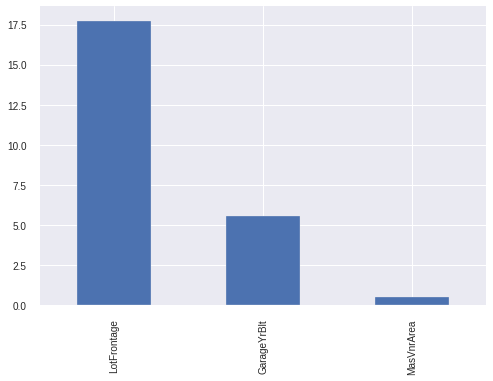

In [10]:
plot_missings(train_num)

In [9]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 348
Remaining NAs for numerical features in train : 0


In [10]:
print("Remaining NAs for cat features in train : " + str(train_cat.isnull().values.sum()))

Remaining NAs for cat features in train : 6617


# Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [ ]:
lr = LinearRegression()

lr.fit(X_train,y_train)

test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)
print('rmse on train',rmse_CV_train(lr).mean())
print('rmse on train',rmse_CV_test(lr).mean())